In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import json
import os

import matplotlib.pyplot as plt

from collections import defaultdict

import Bio
from Bio import SeqIO
from Bio import pairwise2
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.pairwise2 import format_alignment
from Bio.SubsMat import MatrixInfo as matlist

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import nn
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pl_bolts.models import VAE

C:\Users\s2118339\anaconda3\envs\VC\lib\site-packages\Bio\SubsMat\__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


In [2]:
from protein_map_visualisation_tools import generate_embedding_map_from_database

In [3]:
FILENAME = "1_in_500_cleaned_aligned.afa" 

# Variational Autoencoder

In [4]:
SEQ_LEN = 1282  # 18   # restricted to 1271 aa sequence lenghts
AA_ENC_DIM = 21   # count of amino acid encoding dimensions
SEP = os.sep

In [5]:
class StandardDataset(Dataset):

    def __init__(self, filename, seq_len=SEQ_LEN, max_seq_len=SEQ_LEN):
        self.seq_len = seq_len
        self.max_seq_len = max_seq_len
        
        self.viral_seqs = []
        self.max_len = 0
        
        self.tok = Tokenizer(f"One_hot_2.json", self.max_seq_len)
        
        viral_seq_dict = defaultdict(lambda: 0)
        for record in tqdm(SeqIO.parse(filename, "fasta")):
            seq = str(record.seq)
            viral_seq_dict[seq] += 1

        for seq in viral_seq_dict.keys():
            if len(seq) == seq_len:
                self.viral_seqs.append(seq)
            if len(seq) > self.max_len:
                self.max_len = len(seq)

    def __getitem__(self, idx):
        seq = self.tok.tokenize(self.viral_seqs[idx])
        return (seq, 1)

    def __len__(self):
        return len(self.viral_seqs)


class Tokenizer:
    def __init__(self, filename, max_seq_len):
        f = open(filename)
        self.enc_dict = json.load(f)
        self.dec_dict = {}
        for key, value in self.enc_dict.items():
            if len(key) == 1:
                v = int(torch.max(torch.tensor(value), dim=-1).indices)
                self.dec_dict[v] =  key
        self.max_seq_len = max_seq_len

    def tokenize(self, sequence):
        enc = []
        for aa in sequence[:self.max_seq_len]:
            enc.append(self.enc_dict[aa])

        t = torch.tensor(enc)
        return t.float()
    
    def decode(self, batch):
        batch_size, seq_len, aa_dim = batch.size()
        
        batch_seq = []
        
        h = torch.max(batch, dim=-1).indices
        
        for b in range(batch_size):
            seq = ""
            for s in range(seq_len):
                seq += self.dec_dict[int(h[b][s])]
            batch_seq.append(seq)
        
        return batch_seq

## Fully connected

In [59]:
# encoder parameters
ENC_INT_DIM = 512 # intermediate dimensions of the encoder
ENC_OUT_DIM = 128 # output dimensions of the encoder

# latent space
LATENT_DIM = 2   # dimensions of the latent space

# decoder parameters
DEC_INT_DIM = 512 # intermediate dimensions of the decoder

# VAE parameters
KL_COEFF = 0.0    # weighting of the KL divergence in the loss function
KL_MAX = 0.005
KL_CYCLE = 200
KL_WARMUP = 200

# training parameters
LR = 3e-4         # the learning rate
BATCH_SIZE = 64   # batch size
DROPOUT = 0.05
WEIGHT_DECAY = 1e-6 # 3e-5

In [60]:
# lightning-bolts/pl_bolts/models/autoencoders/basic_vae/basic_vae_module.py
# https://github.com/PyTorchLightning/Lightning-Bolts/blob/master/pl_bolts/models/autoencoders/basic_vae/basic_vae_module.py#L18-L186

class Encoder_Fully(torch.nn.Module):
    def __init__(self,
        enc_input_dim: int,
        enc_int_dim: int,
        enc_out_dim: int,
        enc_dropout: float
    ):
        super().__init__()
        self.enc_input_dim = enc_input_dim
        self.enc_int_dim = enc_int_dim
        self.enc_out_dim = enc_out_dim
        self.enc_dropout = enc_dropout
        
        self.l1 = nn.Linear(self.enc_input_dim, self.enc_int_dim)
        self.b1 = nn.BatchNorm1d(enc_int_dim)
        
        self.d2 = nn.Dropout(enc_dropout)
        self.l2 = nn.Linear(self.enc_int_dim, self.enc_int_dim)
        self.b2 = nn.BatchNorm1d(enc_int_dim)
        
        self.d3 = nn.Dropout(enc_dropout)
        self.l3 = nn.Linear(self.enc_int_dim, self.enc_int_dim)
        self.b3 = nn.BatchNorm1d(enc_int_dim)
        
        self.d4 = nn.Dropout(enc_dropout)
        self.l4 = nn.Linear(self.enc_int_dim, self.enc_int_dim)
        self.b4 = nn.BatchNorm1d(enc_int_dim)
        
        self.d5 = nn.Dropout(enc_dropout)
        self.l5 = nn.Linear(self.enc_int_dim, self.enc_out_dim)
        
    def forward(self, x):
        x = self.l1(x)
        x = self.b1(x)
        x = F.relu(x)
        
        x = self.d2(x)
        x = self.l2(x)
        x = self.b2(x)
        x = F.relu(x)
        
        x = self.d3(x)
        x = self.l3(x)
        x = self.b3(x)
        x = F.relu(x)
        
        x = self.d4(x)
        x = self.l4(x)
        x = self.b4(x)
        x = F.relu(x)
        
        x = self.d5(x)
        x = self.l5(x)
        return x
    
    
class Decoder_Fully(torch.nn.Module):
    def __init__(self, 
        latent_dim: int,
        dec_int_dim: int,
        dec_out_dim: int,
        dec_dropout: float
    ):
        super().__init__()
        self.dec_input_dim = latent_dim
        self.dec_int_dim = dec_int_dim
        self.dec_out_dim = dec_out_dim
        self.dec_dropout = dec_dropout
        
        self.l1 = nn.Linear(self.dec_input_dim, self.dec_int_dim)
        self.b1 = nn.BatchNorm1d(dec_int_dim)
        
        self.d2 = nn.Dropout(dec_dropout)
        self.l2 = nn.Linear(self.dec_int_dim, self.dec_int_dim)
        self.b2 = nn.BatchNorm1d(dec_int_dim)
        
        self.d3 = nn.Dropout(dec_dropout)
        self.l3 = nn.Linear(self.dec_int_dim, self.dec_int_dim)
        self.b3 = nn.BatchNorm1d(dec_int_dim)
        
        self.d4 = nn.Dropout(dec_dropout)
        self.l4 = nn.Linear(self.dec_int_dim, self.dec_int_dim)
        self.b4 = nn.BatchNorm1d(dec_int_dim)
        
        self.d5 = nn.Dropout(dec_dropout)
        self.l5 = nn.Linear(self.dec_int_dim, self.dec_out_dim)
        
    def forward(self, x):
        x = self.l1(x)
        x = self.b1(x)
        x = F.relu(x)
        
        x = self.d2(x)
        x = self.l2(x)
        x = self.b2(x)
        x = F.relu(x)
        
        x = self.d3(x)
        x = self.l3(x)
        x = self.b3(x)
        x = F.relu(x)
        
        x = self.d4(x)
        x = self.l4(x)
        x = self.b4(x)
        x = F.relu(x)
        
        x = self.d5(x)
        x = self.l5(x)
        
        return x
    

class VAE_Fully(pl.LightningModule):
    """Standard VAE with Gaussian Prior and approx posterior.
    """

    def __init__(
        self,
        aa_dim: int = AA_ENC_DIM,
        sequence_len: int = SEQ_LEN,
        enc_int_dim: int = ENC_INT_DIM,
        enc_out_dim: int = ENC_OUT_DIM,
        latent_dim: int = LATENT_DIM,
        dec_int_dim: int = DEC_INT_DIM,
        kl_coeff: float = KL_COEFF,
        KL_max = KL_MAX,
        KL_cycle: int = KL_CYCLE,
        KL_warmup: int = KL_WARMUP,
        lr: float = LR,
        batch_size: int = BATCH_SIZE,
        dropout: float = DROPOUT,
        weight_decay: float = WEIGHT_DECAY,
        **kwargs,
    ):
        super().__init__()

        self.save_hyperparameters()

        self.aa_dim = aa_dim
        self.sequence_len = sequence_len
        self.enc_int_dim = enc_int_dim
        self.enc_out_dim = enc_out_dim
        self.latent_dim = latent_dim
        self.dec_int_dim = dec_int_dim
        self.kl_coeff = kl_coeff
        self.KL_max = KL_max
        self.KL_cycle = KL_cycle
        self.KL_warmup = KL_warmup
        self.lr = lr
        self.batch_size = batch_size
        self.dropout = dropout
        self.weight_decay = weight_decay

        self.ds = None
        self.dl = None

        self.encoder = Encoder_Fully(
            enc_input_dim = self.aa_dim*sequence_len,
            enc_int_dim = self.enc_int_dim,
            enc_out_dim = self.enc_out_dim,
            enc_dropout = dropout
        )

        self.decoder = Decoder_Fully(
            latent_dim = self.latent_dim,
            dec_int_dim = self.dec_int_dim,
            dec_out_dim = self.aa_dim*sequence_len,
            dec_dropout = dropout
        )

        self.fc_mu = nn.Linear(self.enc_out_dim, self.latent_dim)
        self.fc_var = nn.Linear(self.enc_out_dim, self.latent_dim)
        
        self.z = None

    def forward(self, x):
        self.z, x_hat_logit, _, _ = self._run_step(x)
        x_hat_logit = x_hat_logit.reshape(-1, self.sequence_len, self.aa_dim)
        x_hat = torch.nn.functional.softmax(x_hat_logit, -1)
        return x_hat
    
    def forward_mu(self, x):
        x = torch.flatten(x, start_dim=-2)
        x = self.encoder(x)
        x = F.relu(x)
        mu = self.fc_mu(x)
        x_hat_logit = self.decoder(mu).reshape(-1, self.sequence_len, self.aa_dim)
        x_hat = torch.nn.functional.softmax(x_hat_logit, -1)
        return x_hat

    def _run_step(self, x):
        x = torch.flatten(x, start_dim=-2)
        x = self.encoder(x)
        x = F.relu(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        p, q, z = self.sample(mu, log_var)
        return z, self.decoder(z), p, q

    def sample(self, mu, log_var):
        std = torch.exp(log_var / 2)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        return p, q, z

    def step(self, batch, batch_idx):
        x, y = batch
        
        z, x_hat_logit, p, q = self._run_step(x)

        #recon_loss = F.mse_loss(x_hat, x, reduction="mean")
        recon_loss = F.cross_entropy(
            x_hat_logit.view(-1, self.aa_dim),
            torch.max(x, dim=-1).indices.contiguous().view(-1))

        kl = torch.distributions.kl_divergence(q, p)
        kl = kl.mean()

        loss = kl*self.kl_coeff + recon_loss
        
        self.p = p
        self.q = q
        self.kl_loss = kl
        self.recon_loss = recon_loss

        logs = {
            "recon_loss": recon_loss,
            "kl": kl,
            "kl_coeff": self.kl_coeff,
            "loss": loss,
        }
        return loss, logs
    
    def on_train_epoch_start(self):
        if self.KL_cycle > 0:
            self.kl_coeff = min(2 * (self.current_epoch % self.KL_cycle) / self.KL_cycle, 1) * self.KL_max
            
        if self.current_epoch <= self.KL_warmup:
            self.kl_coeff = 0

    def training_step(self, batch, batch_idx):
        loss, logs = self.step(batch, batch_idx)
        self.log_dict({f"train_{k}": v for k, v in logs.items()}, on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, logs = self.step(batch, batch_idx)
        self.log_dict({f"val_{k}": v for k, v in logs.items()})
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        self.dl = DataLoader(self.ds,
                        shuffle=True,
                        batch_size=self.batch_size)
        return self.dl

In [61]:
VAE = VAE_Fully(
        aa_dim = AA_ENC_DIM,
        sequence_len = SEQ_LEN,
        enc_int_dim = ENC_INT_DIM,
        enc_out_dim = ENC_OUT_DIM,
        latent_dim = LATENT_DIM,
        dec_int_dim = DEC_INT_DIM,
        kl_coeff = KL_COEFF,
        KL_max = KL_MAX,
        KL_cycle = KL_CYCLE,
        KL_warmup = KL_WARMUP,
        lr = LR,
        batch_size = BATCH_SIZE,
        dropout = DROPOUT,
        weight_decay = WEIGHT_DECAY
)

print(f"ONLY sequences of length {SEQ_LEN} considered")

ONLY sequences of length 1282 considered


In [62]:
ds = StandardDataset(FILENAME,  SEQ_LEN, SEQ_LEN)


2274it [00:00, 51283.99it/s]


In [63]:
VAE.ds = ds

In [64]:
KL_COEFF

0.0

In [65]:
KL_CYCLE

200

In [66]:
trainer = Trainer(max_epochs=5000, gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(VAE)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params
------------------------------------------
0 | encoder | Encoder_Fully | 14.6 M
1 | decoder | Decoder_Fully | 14.6 M
2 | fc_mu   | Linear        | 258   
3 | fc_var  | Linear        | 258   
------------------------------------------
29.2 M    Trainable params
0         Non-trainable params
29.2 M    Total params
116.990   Total estimated model params size (MB)


Epoch 726:   3%|████▌                                                                                                                                                                | 1/36 [00:00<00:06,  5.28it/s, loss=0.014, v_num=58]

In [24]:
trainer.save_checkpoint("Fully_5000epochs_5e-2KL.ckpt")

In [56]:
VAE = VAE_Fully.load_from_checkpoint(checkpoint_path="Fully_5000epochs.ckpt")
VAE = VAE.cuda()

In [34]:
j = 0

In [35]:
ds.viral_seqs[j]

'MFVFLVLLPLVSSQCVNLITRTQ---SYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHA-IHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLDV-YYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLGR----D---LPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNFAPFFAFKCYGVSPTKLNDLCFTNVYADSFVIRGNEVSQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLRSYGFRPTYGVGHQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEYVNNSYECDIPIGAGICASYQTQTKSHRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLKRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKYFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNHNAQALNTLVKQLSSKFGAISSVLNDILSRLDKVEAE

In [36]:
VAE.eval()

VAE_Fully(
  (encoder): Encoder_Fully(
    (l1): Linear(in_features=26922, out_features=512, bias=True)
    (b1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (d2): Dropout(p=0.05, inplace=False)
    (l2): Linear(in_features=512, out_features=512, bias=True)
    (b2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (d3): Dropout(p=0.05, inplace=False)
    (l3): Linear(in_features=512, out_features=512, bias=True)
    (b3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (d4): Dropout(p=0.05, inplace=False)
    (l4): Linear(in_features=512, out_features=512, bias=True)
    (b4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (d5): Dropout(p=0.05, inplace=False)
    (l5): Linear(in_features=512, out_features=128, bias=True)
  )
  (decoder): Decoder_Fully(
    (l1): Linear(in_features=2, out_features=512, bias=True)
    (b1): BatchNorm1d(5

In [37]:
h = ds.tok.decode(VAE.forward_mu(ds.tok.tokenize(ds.viral_seqs[j]).unsqueeze(dim=0).cuda()).reshape(1, SEQ_LEN, -1))
h

['MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHV---ISGTNGTKRFDNPVLPFNDGVYFASIEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLD---YHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPI-LVR----D---LPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNLAPFFTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLRSYSFRPTYGVGHQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLKGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEYVNNSYECDIPIGAGICASYQTQTKSHRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLKRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKYFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFKGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNHNAQALNTLVKQLSSKFGAISSVLNDIFSRLDKVEA

In [38]:
alignments = pairwise2.align.globalxx(ds.viral_seqs[j], h[0])

In [40]:
print(format_alignment(*alignments[0]))

MFVFLVLLPLVSSQCVNLIT-RTQ---S----YTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHA----IHVSGTNGTKRFDNPVLPFNDGVYFAST-EKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLDV-Y--YHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPIN-LG-R----D---LPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNF-APFFA-FKCYGVSPTKLNDLCFTNVYADSFVIRGN-EVS-QIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLRSYG-FRPTYGVGHQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLT-GTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEYVNNSYECDIPIGAGICASYQTQTKSHRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLKRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKYFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFN-GLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNHNAQALNTLVKQLSSKFG

In [41]:
j += 1
h = ds.tok.decode(VAE.forward_mu(ds.tok.tokenize(ds.viral_seqs[j]).unsqueeze(dim=0).cuda()).reshape(1, SEQ_LEN, -1))
alignments = pairwise2.align.globalxx(ds.viral_seqs[j], h[0])
print(format_alignment(*alignments[0]))

MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHV---ISGTNGTKRFDNPVLPFNDGVYFASIEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLD----HKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPI-IVR----EPEDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFG-EVFNATRFASVYAWNRKRISNCVADYSVLYNS-AS-FS-TFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVSGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLRSYSFRPTYGVGHQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLKGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEYVNNSYECDIPIGAGICASYQTQTKSHRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLN-RALTGIAVEQDKNTQEVFAQVKQIYKTPPIKD-FGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFKGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNHNAQALNTLVKQLSSKFGAISSVLNDIFSRLD

In [161]:
seqs_recon = []
for seq in ds.viral_seqs:
    

SyntaxError: unexpected EOF while parsing (Temp/ipykernel_33476/1300510402.py, line 3)

Epoch 247: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:15<00:00,  2.37it/s, loss=0.0556, v_num=47]

## latent space

In [42]:
mus = []
log_vars = []
latents = []

Mu_Xs, Mu_Ys = [], []
Latent_Xs, Latent_Ys = [], []

for seq in tqdm(VAE.ds.viral_seqs):
    x = ds.tok.tokenize(seq).unsqueeze(dim=0).cuda()
    encoded = VAE.encoder(torch.flatten(x, start_dim=-2))
    mu = VAE.fc_mu(encoded)
    mus.append(mu.detach())
    log_var = VAE.fc_var(encoded)
    log_vars.append(log_var.detach())
    p, q, z = VAE.sample(mu, log_var)
    latents.append(z.detach())
    
    Mu_Xs.append(float(mu[0][0].detach()))
    Mu_Ys.append(float(mu[0][1].detach()))
    
    Latent_Xs.append(float(z[0][0].detach()))
    Latent_Ys.append(float(z[0][1].detach()))


 45%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 1020/2274 [00:03<00:04, 259.90it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2152/2274 [00:07<00:00, 323.11it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2274/2274 [00:07<00:00, 295.70it/s]


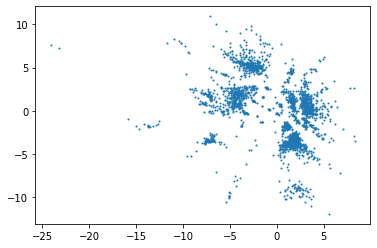

In [43]:
plt.scatter(Mu_Xs, Mu_Ys, s=1)

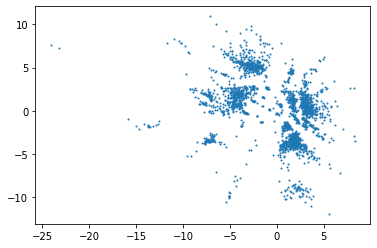

In [44]:
plt.scatter(Latent_Xs, Latent_Ys, s=1)
# plt.xlim((-100, 100))
# plt.ylim((-100, 100))

(array([  2.,   0.,   3.,  11.,  30., 294., 613., 571., 718.,  32.]),
 array([-24.12975311, -20.88434362, -17.63893414, -14.39352465,
        -11.14811516,  -7.90270567,  -4.65729618,  -1.41188669,
          1.8335228 ,   5.07893229,   8.32434177]),
 <BarContainer object of 10 artists>)

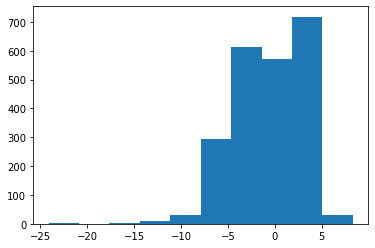

In [45]:
plt.hist(Latent_Xs)

(array([ 22.,  46.,  38., 460., 264., 697., 327., 352.,  60.,   8.]),
 array([-11.96631908,  -9.67512274,  -7.38392639,  -5.09273005,
         -2.8015337 ,  -0.51033735,   1.78085899,   4.07205534,
          6.36325169,   8.65444803,  10.94564438]),
 <BarContainer object of 10 artists>)

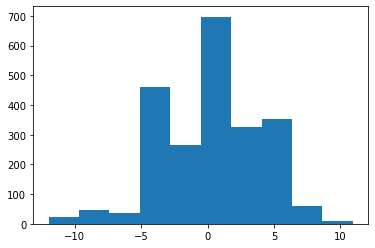

In [46]:
plt.hist(Latent_Ys)

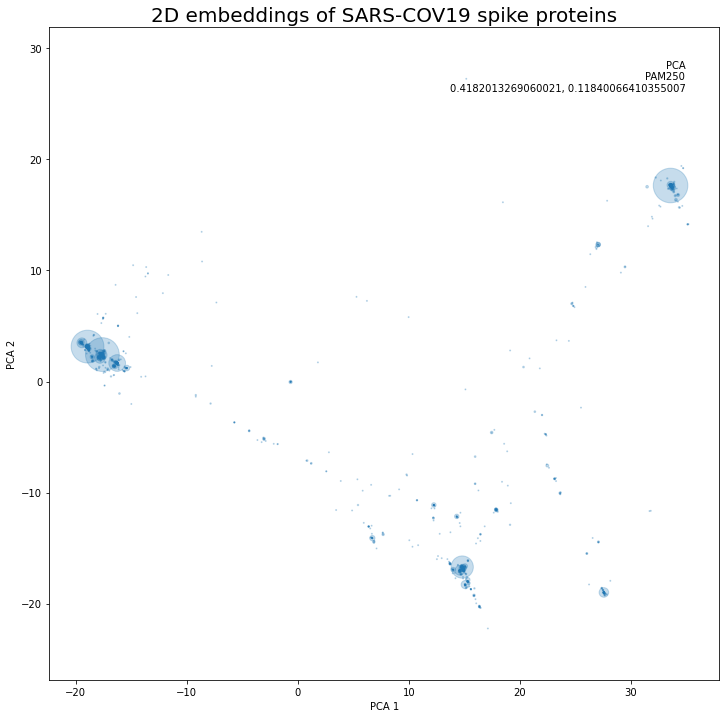

In [28]:
generate_embedding_map_from_database(FILENAME)

In [29]:
FILENAME

'1_in_500_cleaned_aligned.afa'

# generate sequences

In [47]:
FILENAME_GENERATED = "generated2"

In [48]:
device = VAE.device

In [49]:
device = torch.device('cuda')

In [55]:
SAMPLES = 10000

p = torch.distributions.Normal(torch.zeros(LATENT_DIM, device=device), torch.ones(LATENT_DIM, device=device))

In [56]:
Zs = q.sample(sample_shape=torch.Size([SAMPLES]))

In [57]:
VAE.eval()
seqs = defaultdict(lambda : 0)
for z in tqdm(Zs):
    seq = VAE.decoder(z)
    seq = ds.tok.decode(seq.reshape(1, SEQ_LEN, -1))[0]
    seqs[seq] += 1



  1%|██                                                                                                                                                                                               | 109/10000 [00:04<07:54, 20.83it/s]


  2%|████▎                                                                                                                                                                                            | 226/10000 [00:08<04:37, 35.25it/s]


  3%|██████▌                                                                                                                                                                                          | 342/10000 [00:13<08:41, 18.51it/s]


  5%|████████▊                                                                                                                                                                                        | 458/10000 [00:17<05:27, 29.16it/s]


  6%|███████████                                                                                                                                                                                      | 572/10000 [00:21<04:21, 36.11it/s]


  7%|█████████████▊                                                                                                                                                                                   | 714/10000 [00:26<05:02, 30.67it/s]


  8%|███████████████▏                                                                                                                                                                                 | 790/10000 [00:29<05:43, 26.83it/s]


KeyboardInterrupt: 

In [31]:
seqs

defaultdict(<function __main__.<lambda>()>,
            {'MFVFLVLLPLVSSQCVNLRTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHA-IHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGV-YYHKNNKSWMESG--VYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVR----D---LPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGK

In [58]:
len(seqs)

1

In [71]:
records = []

In [72]:
for seq, cnt in seqs.items():
    record = SeqRecord(Seq(seq), id=f"", description=f"{cnt}")
    records.append(record)

In [73]:
for seq in VAE.ds.viral_seqs:
    record = SeqRecord(Seq(seq), id=f"", description=f"{cnt}")
    records.append(record)   

In [74]:
fd = open(f".{os.sep}data{os.sep}spike_protein_sequences{os.sep}{FILENAME_GENERATED}.fasta", "w")
#for record in records:
SeqIO.write(records, fd, format="fasta")

2542

In [75]:
fd.close()

In [76]:
FILENAME_GENERATED

'generated2'

In [77]:
from Bio.Align.Applications import MuscleCommandline

In [56]:
cline = MuscleCommandline(input=f".{os.sep}data{os.sep}spike_protein_sequences{os.sep}{FILENAME_GENERATED}.fasta", out=f".{os.sep}data{os.sep}spike_protein_sequences{os.sep}{FILENAME_GENERATED}.aln", clwstrict=True)
print(cline)

muscle -in .\data\spike_protein_sequences\generated.fasta -out .\data\spike_protein_sequences\generated.aln -clwstrict


In [57]:
stdout, stderr = cline()

ApplicationError: Non-zero return code 2 from 'muscle -in .\\data\\spike_protein_sequences\\generated.fasta -out .\\data\\spike_protein_sequences\\generated.aln -clwstrict', message 'MUSCLE v3.8.31 by Robert C. Edgar'

In [78]:
generate_embedding_map_from_database(f"{FILENAME_GENERATED}.aln")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\s2118339\\Documents\\2022H1\\Group_project\\CovidProject\\week_4/data/spike_protein_sequences/generated2.aln'

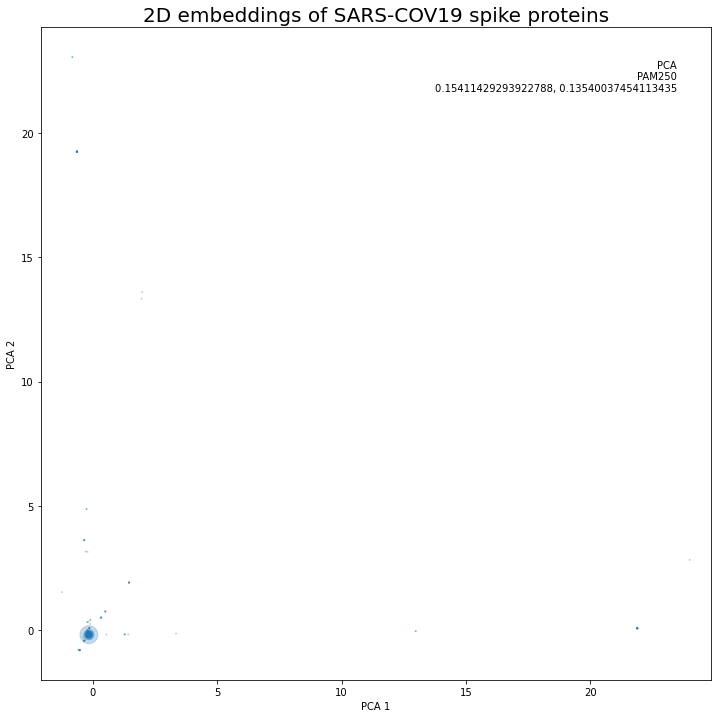

In [62]:
generate_embedding_map_from_database(f"{FILENAME_GENERATED}.aln")